In [4]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-e-16-237.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


In [168]:
def island_cumsum_vectorized(a):
    a_ext = np.concatenate(( [0], a, [0] ))
    idx = np.flatnonzero(a_ext[1:] != a_ext[:-1])
    a_ext[1:][idx[1::2]] = idx[::2] - idx[1::2]
    return a_ext.cumsum()[1:-1]

def max_suffix_string(g1, g2):
    """Return the length of the maximal phased suffix genotype match.
    g1, g2: phased genotypes in format [l,2]
    Return [l] integer array"""
    suffix_strings = np.array([island_cumsum_vectorized(g1[:,i] == g2[:,j]) 
                               for i in range(2) for j in range(2)])
    max_suffix = np.max(suffix_strings, axis=0)
    return max_suffix

def moving_average(a, n=3):
    """Calculates sliding window average in linear time"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_string_match(m, max_str, figsize=(12,4), s=12, ylim=[0,100], 
                      title="", c="darkviolet", savepath="", dpi=300):
    """Plot length of longest matching strings"""
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.scatter(m, max_str, s=s, c=c)
    ax.set_ylim(ylim)
    ax.set_ylabel("Longest String Match across 4 haplotypes")
    ax.set_xlabel("centimorgan")
    ax.set_title(title)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()

In [55]:
f = h5py.File("./data/hdf5/1240k_v43/ch9.h5", "r") # Load for Sanity Check. See below!

In [57]:
j1 = get_idx_iid(f, "COR001")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "COR002")
print(get_coverage(f, j2))

0.8464538858365138
1.1300381663381285


Filtering to 0.98 GP variants: 0.904x
Filtering to 0.98 GP variants: 0.935x
Filtering to common GP variants: 0.867x


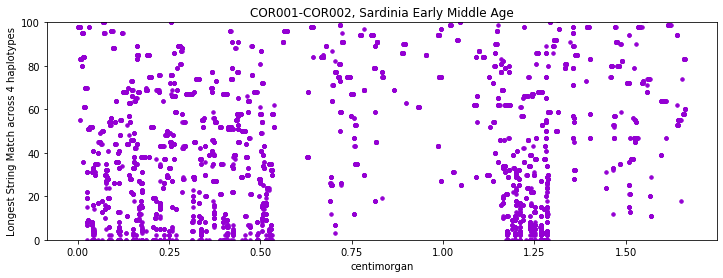

CPU times: user 741 ms, sys: 96.2 ms, total: 837 ms
Wall time: 808 ms


In [60]:
%%time
g1, g2, m = get_genos_pairs(f, sample1="COR001", sample2="COR002", 
                            cutoff=0.98, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="COR001-COR002, Sardinia Early Middle Age")

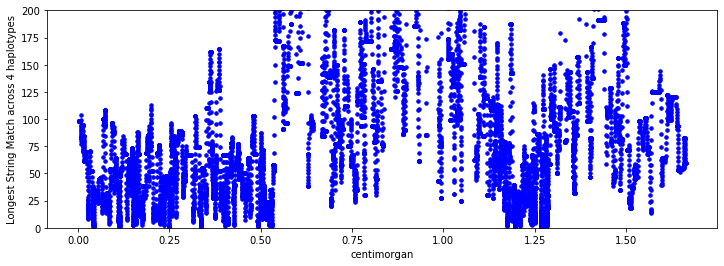

In [62]:
avg_str=moving_average(max_str, n=10)
plot_string_match(m[5:-4], avg_str, title="", ylim=[0,200], c="blue")

Filtering to 0.98 GP variants: 0.865x
Filtering to 0.98 GP variants: 0.922x
Filtering to common GP variants: 0.820x


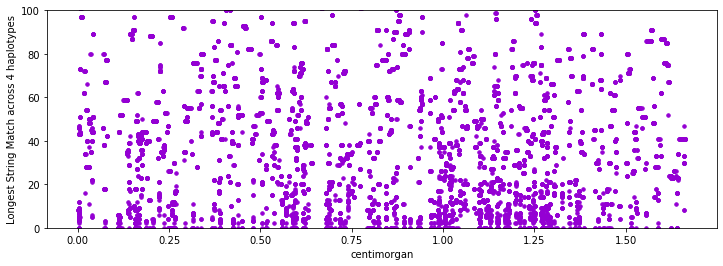

CPU times: user 746 ms, sys: 85.7 ms, total: 831 ms
Wall time: 802 ms


In [65]:
%%time
g1, g2, m = get_genos_pairs(f, sample1="SUC002", sample2="SUC005", 
                            cutoff=0.98, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="")

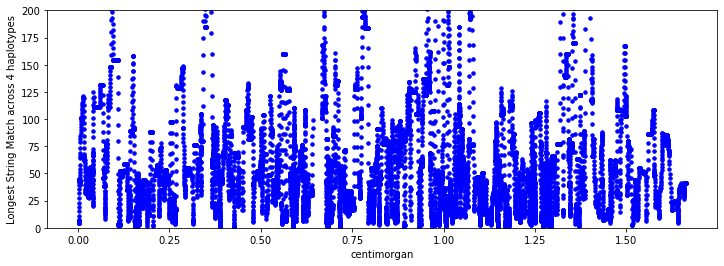

In [66]:
avg_str=moving_average(max_str, n=10)
plot_string_match(m[5:-4], avg_str, title="", ylim=[0,200], c="blue")

Filtering to 0.95 GP variants: 0.978x
Filtering to 0.95 GP variants: 0.952x
Filtering to common GP variants: 0.939x


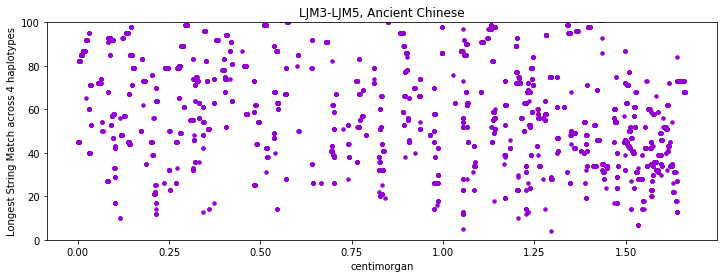

CPU times: user 705 ms, sys: 85.9 ms, total: 791 ms
Wall time: 766 ms


In [30]:
%%time
g1, g2, m = get_genos_pairs(f, sample1="LJM3", sample2="LJM5", 
                            cutoff=0.95, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="LJM3-LJM5, Ancient Chinese")

### Punier

Filtering to 0.95 GP variants: 0.817x
Filtering to 0.95 GP variants: 0.804x
Filtering to common GP variants: 0.703x


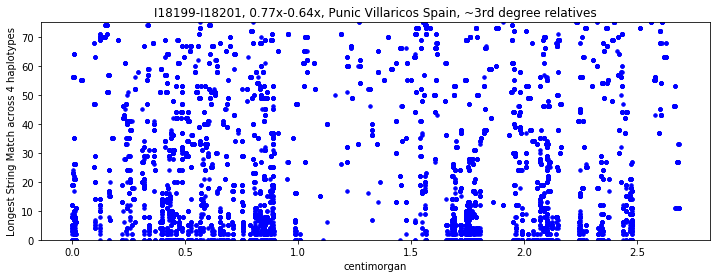

CPU times: user 1.05 s, sys: 168 ms, total: 1.22 s
Wall time: 1.15 s


In [53]:
%%time
f = h5py.File("./data/hdf5/1240k_v43/ch2.h5", "r") # Load for Sanity Check. See below!
g1, g2, m = get_genos_pairs(f, sample1="I18199", sample2="I18201", 
                            cutoff=0.95, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="I18199-I18201, 0.77x-0.64x, Punic Villaricos Spain, ~3rd degree relatives", ylim=[0,75], c="blue")
f.close()

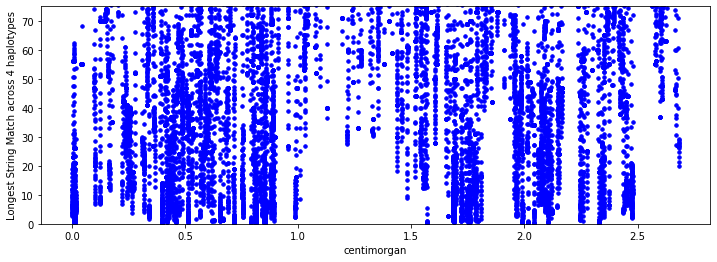

In [54]:
avg_str=moving_average(max_str, n=10)
plot_string_match(m[5:-4], avg_str, title="", ylim=[0,75], c="blue")

# Mesolithic Romania Father Son

In [34]:
j1 = get_idx_iid(f, "I10467")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "I10475.SG")
print(get_coverage(f, j2))

1.9374796979048239
2.814682475231444


Filtering to 0.98 GP variants: 0.934x
Filtering to 0.98 GP variants: 0.990x
Filtering to common GP variants: 0.928x


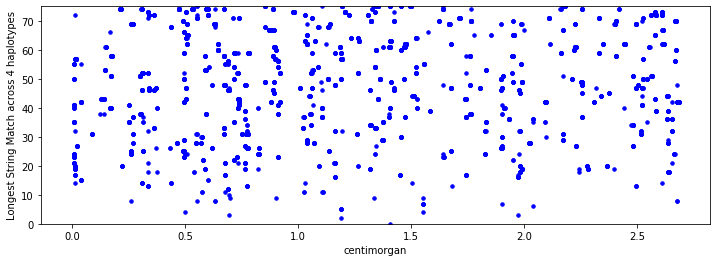

CPU times: user 989 ms, sys: 92.7 ms, total: 1.08 s
Wall time: 1.03 s


In [38]:
%%time
f = h5py.File("./data/hdf5/1240k_v43/ch2.h5", "r") # Load for Sanity Check. See below!
g1, g2, m = get_genos_pairs(f, sample1="I10467", sample2="I10475.SG", 
                            cutoff=0.98, output=True, phased=True)

max_suffix = max_suffix_string(g1, g2)
max_prefix = max_suffix_string(g1[::-1], g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="", ylim=[0,75], c="blue")
f.close()

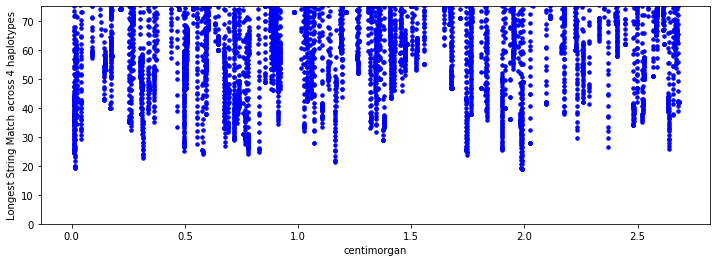

In [49]:
avg_str=moving_average(max_str, n=20)
plot_string_match(m[10:-9], avg_str, title="", ylim=[0,75], c="blue")

# Sister Anatolia N

In [166]:
f = h5py.File("./data/hdf5/1240k_v43/ch1.h5", "r") # Load for Sanity Check. See below!
j1 = get_idx_iid(f, "I0736")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "I0854", unique=False)[0]
print(get_coverage(f, j2))
f.close()

1.6986898647940467
0.9998427837752856


Filtering to 0.98 GP variants: 0.938x
Filtering to 0.98 GP variants: 0.889x
Filtering to common GP variants: 0.853x
Saved to ./figs/dumpster/anatolia_sisters.png


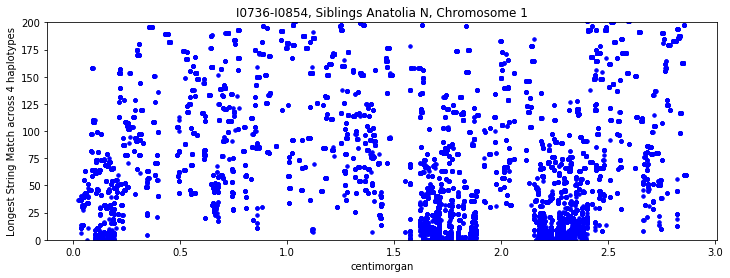

CPU times: user 2.6 s, sys: 145 ms, total: 2.74 s
Wall time: 2.72 s


In [170]:
%%time
f = h5py.File("./data/hdf5/1240k_v43/ch1.h5", "r") # Load for Sanity Check. See below!
g1, g2, m = get_genos_pairs(f, sample1="I0736", sample2="I0854_published", 
                            cutoff=0.98, output=True, phased=True)

max_suffix = max_suffix_string(g1, g2)
max_prefix = max_suffix_string(g1[::-1], g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="I0736-I0854, Siblings Anatolia N, Chromosome 1", ylim=[0,200], c="blue", savepath="./figs/dumpster/anatolia_sisters.png")
f.close()

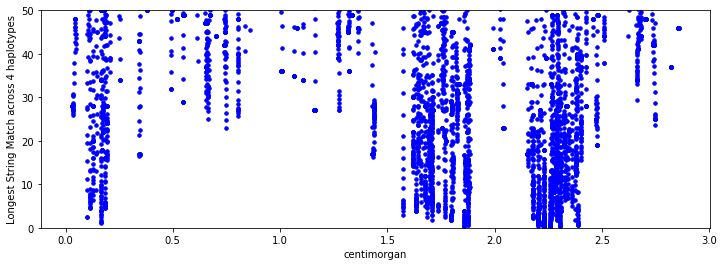

In [93]:
avg_str=moving_average(max_str, n=8)
plot_string_match(m[4:-3], avg_str, title="", ylim=[0,50], c="blue")

# Sister Hungary LN

In [102]:
j1 = get_idx_iid(f, "I10129")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "I10014")
print(get_coverage(f, j2))

2.654627397547427
2.090923383293156


In [ ]:
avg_str=moving_average(max_str, n=8)
plot_string_match(m[4:-3], avg_str, title="", ylim=[0,50], c="blue")

# Caribbean

In [116]:
dfr = pd.read_csv("../caribbean_roh/Data/related/relationshps_revision.csv", sep="\t")

In [157]:
iid1, iid2 = dfr[["Ind1","Ind2"]].loc[43,:]
iid1, iid2

('I17903', 'I17906')

In [153]:
f = h5py.File("./data/hdf5/1240k_v43/ch3.h5", "r") # Load for Sanity Check. See below!
j1 = get_idx_iid(f, iid1)
print(get_coverage(f, j1))
j2 = get_idx_iid(f, iid2)
print(get_coverage(f, j2))
f.close()

1.0700717240704023
1.118565029007858


Filtering to 0.98 GP variants: 0.907x
Filtering to 0.98 GP variants: 0.904x
Filtering to common GP variants: 0.852x


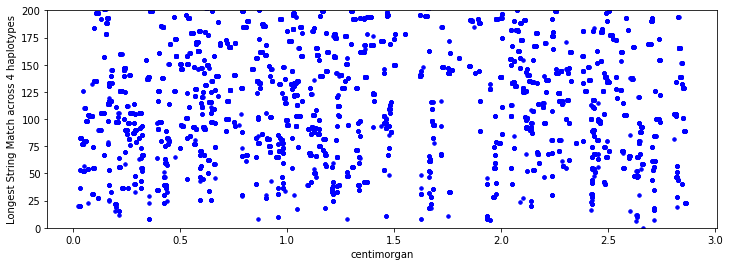

CPU times: user 1.11 s, sys: 126 ms, total: 1.23 s
Wall time: 1.36 s


In [156]:
%%time
f = h5py.File("./data/hdf5/1240k_v43/ch1.h5", "r") # Load for Sanity Check. See below!
g1, g2, m = get_genos_pairs(f, sample1=iid1, sample2=iid2, 
                            cutoff=0.98, output=True, phased=True)

max_suffix = max_suffix_string(g1, g2)
max_prefix = max_suffix_string(g1[::-1], g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="", ylim=[0,200], c="blue")
f.close()

In [132]:
iid1

'I16687'